In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

from micrograd import Value
from nn import MLP

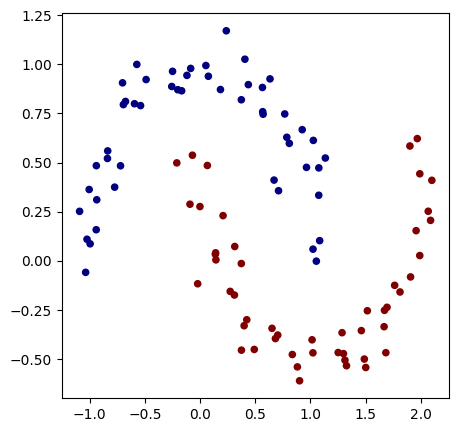

In [2]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1

# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [3]:
# init the MLP model with 2 layers

model = MLP(2, [16, 16, 1])
print(model, "number of params", len(model.parameters()))

MLP of [
Layer of [Neuron([Value(data=-0.5992145853098776), Value(data=0.7679994808743817)]), Neuron([Value(data=-0.20334733524178006), Value(data=-0.4816514428534975)]), Neuron([Value(data=-0.627768422164424), Value(data=0.9900638747424093)]), Neuron([Value(data=-0.807391670505728), Value(data=0.06431296855354995)]), Neuron([Value(data=-0.9045139137243519), Value(data=0.8251374410205814)]), Neuron([Value(data=-0.101407471699827), Value(data=-0.40702431420899887)]), Neuron([Value(data=0.5891091885407935), Value(data=0.6728192835730598)]), Neuron([Value(data=-0.2625366508243141), Value(data=0.2925276450745218)]), Neuron([Value(data=-0.09141362816229792), Value(data=0.5257549350937929)]), Neuron([Value(data=-0.053874044328942716), Value(data=0.17871611518819042)]), Neuron([Value(data=0.8132807805066826), Value(data=-0.40458777517346567)]), Neuron([Value(data=-0.8260720461648134), Value(data=-0.01813421688349881)]), Neuron([Value(data=0.10593107236870414), Value(data=0.33853469390982127)]

In [ ]:
# loss function
def loss():
    Xb, yb = X, y

    # convert input to neuron input value
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward-pass
    scores = [model(x) for x in inputs]

    # if the expected & actual score point in the same direction, then
    # score & label (yi) will be positive. Further, subtracting from 1
    # will make the value < 1 RelU will further trim the values to 0.
    # This way the loss will remain low.
    # However, if the score & label are in opposite directions, then
    # the loss will compulsorily remain above 1.
    # Hence in case of correct answer, loss remains in [0, 1] otherwise [1, +inf]

    # Hinge loss says: Am I on the right side AND far enough away from the boundary?
    # It's like parking - you don't just barely avoid hitting the car next to you,
    # you leave some space for safety.

    # In the real world, predictions near the boundary are uncertain and risky. A point
    # that's barely on the correct side might flip to the wrong side with slight noise
    # or new data. Hinge loss says "I don't trust you until you're confidently correct."
    # This creates a buffer zone around the decision boundary.

    # in this case, the margin is 1. that means, every point is at least 1 unit away from
    # the decision boundary.
    losses = [(1 + (-yi * scorei)).relu() for scorei, yi in zip(scores, yb)]

    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization (weight decay): penalizes large weights by adding α * Σ(wi²)
    # This prevents overfitting by encouraging smaller, more distributed weights
    # rather than relying heavily on any single weight
    """
    This one has multiple beautiful intuitions:

Intuition 1 - Occam's Razor:
Between two models that fit your data equally well, prefer the simpler one.
Small weights = simpler model. A model with weights [100, -80, 95] is "doing more"
than one with [0.5, -0.3, 0.4], even if they both fit the training data.
The simpler one is more likely to generalize.

Intuition 2 - Don't put all eggs in one basket:
Without regularization, the model might put huge weight on one feature and ignore others.
With L2, it's "cheaper" (in terms of loss) to use many small weights than one huge weight.
Example: To get an output of 10, you could use:

One weight: w₁=10 → penalty = 10² = 100
Two weights: w₁=5, w₂=5 → penalty = 5² + 5² = 50 (better!)

This spreads the "responsibility" across features, making the model more robust.

Intuition 3 - Noise resilience:
Large weights amplify noise. If a feature has a tiny bit of noise and it has
weight 1000, that noise gets magnified 1000×. Small weights dampen noise's effect.

Intuition 4 - Geometric view:
L2 regularization keeps weights in a ball around the origin. During training,
you're trying to minimize loss (pulls weights in one direction) while regularization
pulls them back toward zero. The final solution is a compromise - good fit without
going crazy with weight values.
    """
    alpha = 1e-4
    reg_loss = sum((p * p for p in model.parameters())) * alpha

    total_loss = data_loss + reg_loss

    # this is more for info purpose.
    accuracy = [(yi > 0) == (scorei.data > 0) for scorei, yi in zip(scores, yb)]

    return total_loss, sum(accuracy) / len(accuracy)

Another visual of the margin. Notice how H2 & H3, both are valid classification boundaries, but we can clearly see that H3 is better. This is what hinge-loss is helping us determine.

![image.png](attachment:4dfe1a42-ef88-4cac-a2ef-0842e8090c42.png)

In [ ]:
# optimisation
for k in range(100):
    total_loss, acc = loss()

    model.zero_grad()

    total_loss.backward()

    learning_rate = 1.0 - 0.9 * k / 100

    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f"step {k} loss {total_loss.data}, accuracy {acc * 100}%")

(-1.581767921066486, 1.918232078933514)

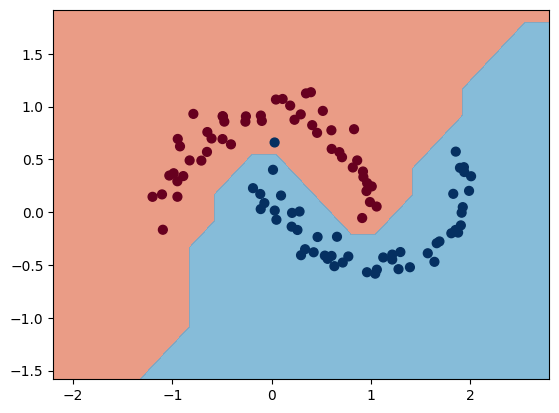

In [6]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())